# Safe Absorbing States

In [8]:
from NN import *
from LTL import *
from Utility_funcs import *

%matplotlib inline
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt
import time
import os


Number of Omega-automaton states (including the trap state): 4


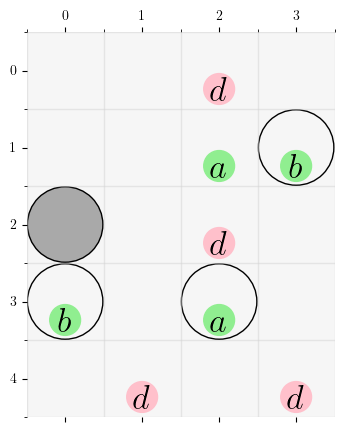

In [9]:
# LTL Specification
ltl = '(F G a | F G b) & G !d'

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
display(oa)

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'T'],
['B',  'E',  'E',  'E'],
['T',  'E',  'T',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),       (),     ('d',),()],
[(),       (),     ('a',),('b',)],
[(),       (),     ('d',),()],
[('b',),   (),     ('a',),()],
[(),       ('d',), (),    ('d',)]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'lightgreen',
    ('b',):'lightgreen',
    ('d',):'pink'
}
p = 0.8
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled(csrl, enc)

In [10]:
full_t = "(<> [] a \/ <> [] b) /\ [] ~d"

LTL_formula = parser.parse(full_t)
predicates=get_predicates(grid_mdp)
predicates

{'a': [6, 14], 'b': [7, 12], 'd': [2, 10, 17, 19]}

In [11]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 4, 4)]    0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 5, 4, 32)     544         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 160)          0           ['conv2d_3[0][0]']               
                                                                                            

In [12]:
model(ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [20]:
# model.load_weights(f'first_case_{p}')

In [13]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10
NN_value_active = False

search_depth = 100
MCTS_samples = 100

num_training_epochs =  100
num_test_epochs = 100
training = True
epochs = 10
C = 1
tow = 0.1
T = [25, 50, 75, 100, 150, 200, 300, 400]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []

# os.remove("Log_run.txt")
for i in T:
    idx += 1
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=C, tow=tow, n_samples=MCTS_samples, visited=visited_train,
                start=None, search_depth=search_depth, verbose=0, T=i, K=K, NN_value_active=NN_value_active, run_num=epoch, ltl_f_rew=False, reachability=True)
        
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0:
            train_wins+=1
            NN_value_active = True

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=1, tow=1, n_samples=MCTS_samples, visited=visited_test,
                start=None, search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True, reachability=True)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

# u, d, r, l

0 ) MCTS conf: -0.1 , det: 0.71 | LTL [+++]  LDBA [ 0.01 ] path: [9, 5, 6, 6]
1 ) MCTS conf: 0.71 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [3, 3, 3, 7, 7]
2 ) MCTS conf: 0.39 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [18, 14, 14]
3 ) MCTS conf: 0.81 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [9, 9, 5, 6, 6]
4 ) MCTS conf: 0.93 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [5, 6, 6]
5 ) MCTS conf: 0.75 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [15, 14, 14]
6 ) MCTS conf: 0.85 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [15, 14, 14]
7 ) MCTS conf: 0.75 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [1, 2]
8 ) MCTS conf: 0.91 , det: 0.76 | LTL [+++]  LDBA [ 0.01 ] path: [4, 5, 6, 6]
9 ) MCTS conf: 0.8 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [1, 5, 6, 6]
10 ) MCTS conf: 0.75 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [13, 14, 14]
11 ) MCTS conf: 0.93 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [0, 4, 5, 6, 6]
12 ) MCTS conf: 0.79 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [15, 14, 

KeyboardInterrupt: 

In [23]:
# u, d, r, l
state = (0, 0, 0, 1)
print(Q[state])
print(N[state])
csrl.transition_probs[state][0]
p

[0.09880504 0.65757654 0.         0.97512509 0.         0.
 0.         0.        ]
[  10.   99.    0. 6995.    0.    0.    0.    0.]


0.8

In [24]:
model.save_weights(filepath=f'models/safe_absorbing_{p}')

[93.0, 95.0, 92.0, 97.0, 91.0, 95.0, 95.0, 98.0]

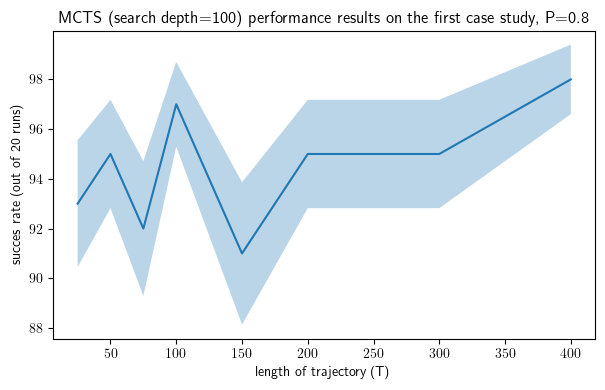

In [25]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 20 runs)")
plt.title("MCTS (search depth="+str(search_depth)+") performance results on the first case study, P="+str(p))
success_rates

In [27]:
Q = np.load(f'Q1_{p}.npy')

In [26]:
Q, _=csrl.q_learning(T=100,K=100000)
np.save(f'Q1_{p}', Q)

KeyboardInterrupt: 

In [28]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [30]:
episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=10, start=None, runs=100, verbose=0)

Running 100 simulations with 10 time-steps...
Test finished with:
	success rate: 39 / 100 = 0.39


In [37]:
np.sum([any([i>0 for i in [csrl.reward[x] for x in episode]]) for episode in episodes])/200

0.73

In [13]:
T = [25, 50, 75, 100, 150, 200, 300, 400]

In [31]:
rewards_mean = []
rewards_std = []
n_runs = 500

for i in T:
    episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=i, start=None, runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 500 simulations with 25 time-steps...
Test finished with:
	success rate: 252 / 500 = 0.504
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 274 / 500 = 0.548
Running 500 simulations with 75 time-steps...
Test finished with:
	success rate: 310 / 500 = 0.62
Running 500 simulations with 100 time-steps...
Test finished with:
	success rate: 315 / 500 = 0.63
Running 500 simulations with 150 time-steps...
Test finished with:
	success rate: 383 / 500 = 0.766
Running 500 simulations with 200 time-steps...
Test finished with:
	success rate: 395 / 500 = 0.79
Running 500 simulations with 300 time-steps...
Test finished with:
	success rate: 438 / 500 = 0.876
Running 500 simulations with 400 time-steps...
Test finished with:
	success rate: 451 / 500 = 0.902


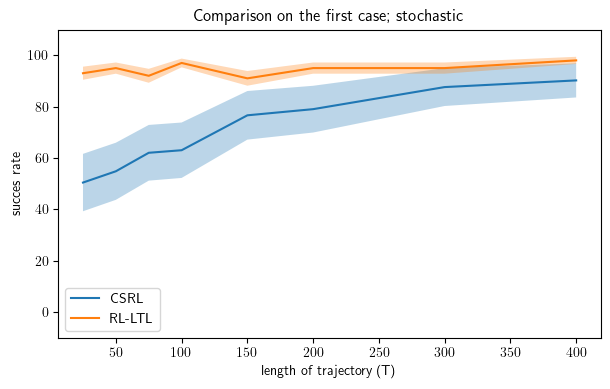

In [32]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the first case; stochastic")
# plt.title("Comparison on the first case; deterministic")
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="RL-LTL")
plt.legend()
plt.savefig(f"res_400/C1_P{p}.pdf")

Text(0.5, 1.0, 'CSRL performance results on the first case study, P=0.8')

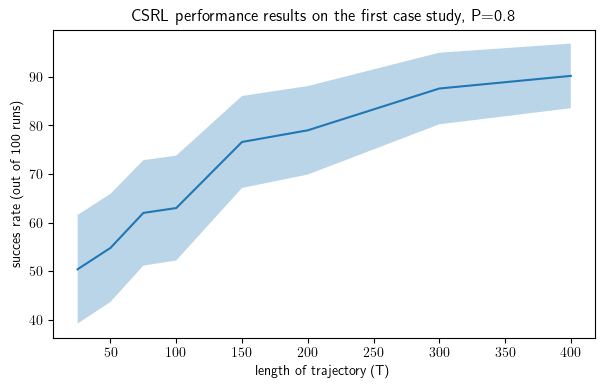

In [33]:
plt.figure(figsize=(7,4))
plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 100 runs)")
plt.title("CSRL performance results on the first case study, P="+str(p))